# B&B vs MILP

In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime, timedelta

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pulp as pl

from alg import *
from utils import *

In [2]:
PT_MAX = 10
NUM_TRIALS = 10

INSTANCES = {}

def rand_p(n, i):
    if (n, i) not in INSTANCES:
        INSTANCES[n, i] = random_instance(n, PT_MAX)
    return INSTANCES[n, i]

for n in range(100):
    for i in range(NUM_TRIALS):
        _ = rand_p(n, i)

In [3]:
def bnb_time(R, p, h, remaining):
    tic = datetime.now()
    _ = bnb(R, p, h, limit=remaining)
    return datetime.now() - tic

def bnb_h1_time(R, p, remaining):
    return bnb_time(R, p, h1, remaining)

def bnb_h2_time(R, p, remaining):
    return bnb_time(R, p, h2, remaining)

def milp_time(R, p, remaining):
    tic = datetime.now()
    _ = milp(R, p, solver=pl.GLPK_CMD(timeLimit=int(remaining.total_seconds()), msg=False))
    return datetime.now() - tic

In [4]:
def timeit_rand(f, R, limit):
    remaining = timedelta(seconds=limit.total_seconds())
    times = []
    n = 0
    while remaining.total_seconds() > 0:
        total = timedelta(0)
        i = 0
        while i < NUM_TRIALS and remaining.total_seconds() > 0:
            consumed = f(R, rand_p(n, i), remaining)
            total += consumed
            remaining -= consumed
            i += 1
            
        if i < NUM_TRIALS:
            break

        times.append(total.total_seconds() / NUM_TRIALS)
        n += 1

    return pd.Series(times)

In [5]:
df = pd.DataFrame({f.__name__: timeit_rand(f, R=8, limit=timedelta(minutes=2)) for f in [bnb_h1_time, bnb_h2_time, milp_time]})
df.tail()

,bnb_h1_time,bnb_h2_time,milp_time
30,2.387684,1.114609,NaN
31,1.471986,0.678103,NaN
32,NaN,2.536143,NaN
33,NaN,1.024559,NaN
34,NaN,1.722884,NaN


<AxesSubplot:xlabel='#tasks', ylabel='avg. runtime [s]'>

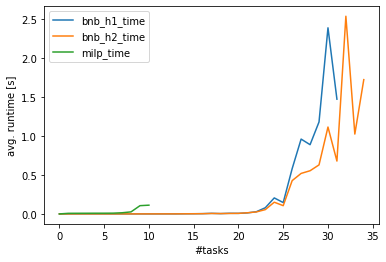

In [6]:
df.plot.line(xlabel='#tasks', ylabel='avg. runtime [s]')

In [7]:
def timeit_subopt(f, limit):
    remaining = timedelta(seconds=limit.total_seconds())
    times = []
    R = 0
    while remaining.total_seconds() > 0:
        consumed = f(R, suboptimal_instance(R), remaining)
        times.append(consumed)
        remaining -= consumed
        R += 1
    return pd.Series(times)

In [8]:
df = pd.DataFrame({f.__name__: timeit_subopt(f, limit=timedelta(minutes=2)) for f in [bnb_h1_time, bnb_h2_time, milp_time]})
df.tail()

,bnb_h1_time,bnb_h2_time,milp_time
27,NaT,0 days 00:00:06.402932,NaT
28,NaT,0 days 00:00:37.348544,NaT
29,NaT,0 days 00:00:05.559169,NaT
30,NaT,0 days 00:00:06.360640,NaT
31,NaT,0 days 00:00:17.905068,NaT


<AxesSubplot:xlabel='#resources', ylabel='runtime on subopt. instance [s]'>

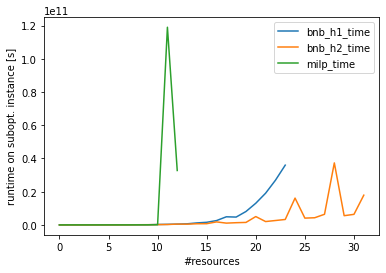

In [9]:
df.plot.line(xlabel='#resources', ylabel='runtime on subopt. instance [s]')